In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data load
# input your data path (.csv)
file_path = "./sample_231103_01.csv"
mdata = np.genfromtxt(file_path, delimiter=",", dtype=int)
# year, month, day, hour, min, seconds, weekend
time_size = 7 
feature_size = mdata.shape[1] - time_size - 1

In [3]:
# sequence data loader 정의
def load_data(raw, look_back, feature_cnt):
    data_raw = raw
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:,:feature_cnt]
    y_train = data[:train_set_size,-1,feature_cnt:]

    x_test = data[train_set_size:,:, :feature_cnt]
    y_test = data[train_set_size:,-1,feature_cnt:]

    return [x_train, y_train, x_test, y_test]

# look back 의 의미 : 특정 크기의 단위만큼 이전 값을 고려한다
# 단위는 초(seconds) 가 될 것이라 예상

In [4]:
# choose sequence length
sequence_size = 10

In [5]:
# Time data parsing
from sklearn.model_selection import train_test_split
x_train_t, x_test_t = train_test_split(mdata[:-sequence_size,:time_size], 
                                                    test_size=0.1, random_state=42,
                                                   shuffle=False)

print('x_train_t.shape = ',x_train_t.shape)
print('x_test_t.shape = ',x_test_t.shape)

x_train_t.shape =  (777591, 7)
x_test_t.shape =  (86399, 7)


In [6]:
# for LSTM layer
# Sensor data parsing

x_train, y_train, x_test, y_test = load_data(mdata[:,time_size :], 
                                            sequence_size,
                                            feature_size)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (777591, 10, 1)
y_train.shape =  (777591, 1)
x_test.shape =  (86399, 10, 1)
y_test.shape =  (86399, 1)


In [7]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Sequential, Model

time_input = Input(shape=(time_size, ))
sensor_input = Input(shape=(sequence_size, feature_size))

In [8]:
# numpy to tensor
x_train_t = tf.convert_to_tensor(x_train_t)
x_test_t = tf.convert_to_tensor(x_test_t)

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [9]:
# 1. LSTM 레이어 정의 -> 센서들을 하나로 합침
sensor_x = LSTM(64)(sensor_input)
sensor_x = Dense(1)(sensor_x)

In [10]:
# 2. LSTM 거친 값들을 하나로 합침
total_x = Concatenate()([time_input, sensor_x])

In [11]:
# 3. 전체 Dense 레이어 정의
total_layer = Dense(64)(total_x)
pred = Dense(1)(total_layer)

In [12]:
model = Model(inputs = [time_input, sensor_input],
             outputs = [pred])

In [13]:
#모델 컴파일
model.compile(optimizer = 'adam',
              loss=['mean_squared_error','mean_squared_error']
             )

In [14]:
# 모델 요약
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 64)                   16896     ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 1)                    65        ['lstm[0][0]']                
                                                                                              

In [15]:
#모델 학습
history = model.fit([x_train_t, x_train], 
                    [y_train], 
                    epochs = 10, 
                    batch_size = 32,
                    validation_split=0.18)

Epoch 1/10
19926/19926 [==============================] - 67s 3ms/step - loss: 113.4743 - val_loss: 31.0650
Epoch 2/10
19926/19926 [==============================] - 65s 3ms/step - loss: 18.9460 - val_loss: 28.5129
Epoch 3/10
19926/19926 [==============================] - 65s 3ms/step - loss: 13.9556 - val_loss: 50.4557
Epoch 4/10
19926/19926 [==============================] - 66s 3ms/step - loss: 11.2037 - val_loss: 1.4625
Epoch 5/10
19926/19926 [==============================] - 65s 3ms/step - loss: 10.3528 - val_loss: 2.6605
Epoch 6/10
19926/19926 [==============================] - 65s 3ms/step - loss: 8.4844 - val_loss: 14.5977
Epoch 7/10
19926/19926 [==============================] - 67s 3ms/step - loss: 7.5855 - val_loss: 31.2403
Epoch 8/10
19926/19926 [==============================] - 66s 3ms/step - loss: 8.3439 - val_loss: 2.0548
Epoch 9/10
19926/19926 [==============================] - 67s 3ms/step - loss: 6.9978 - val_loss: 18.6737
Epoch 10/10
19926/19926 [==================

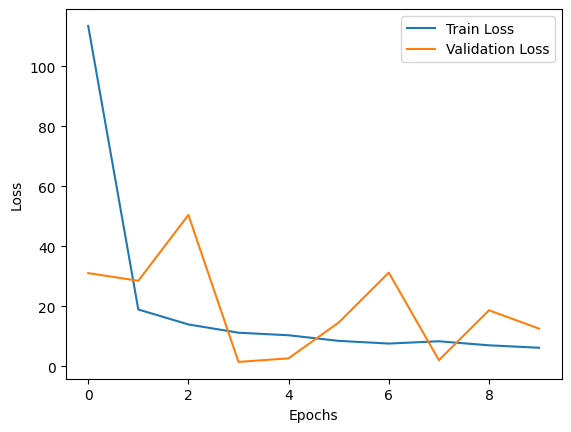

In [16]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# 모델 평가
results = model.evaluate([x_test_t, x_test], y_test)
print(f'Test loss : {results:.3%}')

2700/2700 [==============================] - 4s 2ms/step - loss: 13.1369
Test loss : 1313.686%


2700/2700 [==============================] - 4s 1ms/step


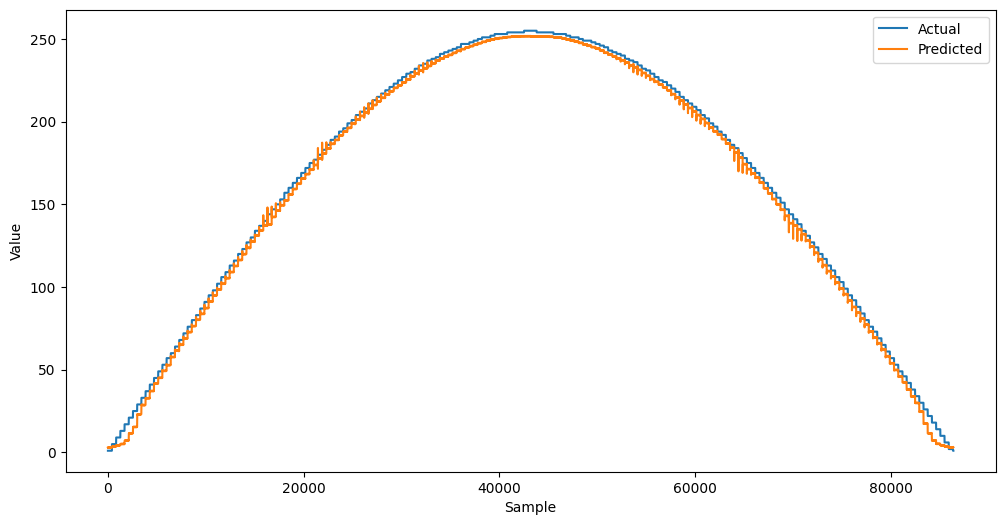

In [18]:
# 예측
y_pred = model.predict([x_test_t, x_test])

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

---

In [19]:
# 하나의 input 값 입력하기
# input : [시각, [10개의 누적된 센서 값]]
test_input_t = x_test_t[-1,:]
test_input = x_test[-1,:]

In [20]:
test_input_t = tf.reshape(test_input_t, [1, time_size])

In [21]:
test_input = tf.reshape(test_input, [1, sequence_size, feature_size])

In [22]:
test_ans = y_test[-1]
print(test_ans)

tf.Tensor([1], shape=(1,), dtype=int64)


In [23]:
test_pre = model.predict([test_input_t, test_input])
print(test_pre)

1/1 [==============================] - 0s 14ms/step
[[3.0759954]]


In [24]:
# 학습한 모델 저장
model.save("LSTM_DNN_231103_01")

INFO:tensorflow:Assets written to: DNN_231103_01/assets


INFO:tensorflow:Assets written to: DNN_231103_01/assets


### 하이퍼 파라미터 튜닝

- 모델의 성능을 개선하기 위해 변수들을 조절함
- 모델은 추론에 있어 정확성을 지니면서, 동시에 과적합을 방지해야 함
- 현재 프로세스에서 튜닝할 수 있는 파라미터들
    - **sqeuence_size (= look_back)**
    - **LSTM layer의 hidden_size**
    - batch_size
    - learning_rate
    - 활성화 함수
    - 최적화 함수
    - 계층의 크기(혹은 깊이) 등...